# **Import Library**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.stats as st
import math
import datetime
import missingno as msno
from scipy.stats import norm, skew
from sklearn import metrics
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from termcolor import colored
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#to see model hyperparameters
from sklearn import set_config
set_config(print_changed_only = False)

# to show all columns
pd.set_option('display.max_columns', 15)

# **Load Dataset**

In [3]:
car = pd.read_csv("../input/vehicle-dataset-from-cardekho/Car details v3.csv")
df = car.copy()
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
print("Rows: {0}, columns: {1}".
      format(df.shape[0], df.shape[1]))

Rows: 8128, columns: 13


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


There are null values in 'mileage' (221), 'engine' (221), 'max_power' (215), 'torque' (222), 'seats' (221) variables.

The dataset consists of 8128 rows and 13 columns.

Of the variables, 9 are object, 3 are integer and 1 are float                                                                    

# **Convert values of the columns and change dtypes**

In [6]:
#make dtypes of some variables 'category'

categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    df[column] = df[column].astype("category")

In [7]:
#create 'car_brand_name' feature from 'name' feature

df["car_brand_name"] = df["name"].str.extract('([^\s]+)')
df["car_brand_name"] = df["car_brand_name"].astype("category")

In [8]:
#extract values of 'engine' and 'mileage' variables

df["engine"] = df["engine"].str.extract('([^\s]+)').astype("float")
df["mileage"] = df["mileage"].str.extract('([^\s]+)').astype("float")

In [9]:
#extract values of 'max_power' variable

df["max_power"] = df["max_power"].str.extract('([^\s]+)')
df["max_power"] = df["max_power"][~(df["max_power"] == "bhp")]
df["max_power"] = df["max_power"].astype("float")

In [10]:
#create 'car_age' feature from 'year' column

df["car_age"] = (datetime.datetime.now().year) - (df["year"])

In [11]:
df.drop(["name", "year", "torque"], axis = 1, inplace = True)

In [12]:
df.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti,10
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda,10
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda,18
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai,14
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti,17


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   seller_type     8128 non-null   category
 4   transmission    8128 non-null   category
 5   owner           8128 non-null   category
 6   mileage         7907 non-null   float64 
 7   engine          7907 non-null   float64 
 8   max_power       7912 non-null   float64 
 9   seats           7907 non-null   float64 
 10  car_brand_name  8128 non-null   category
 11  car_age         8128 non-null   int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 486.3 KB


# **Get additional information about the dataset**

In [14]:
# check whether there are null values in the dataset
df.isnull().sum()

selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           221
engine            221
max_power         216
seats             221
car_brand_name      0
car_age             0
dtype: int64

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
selling_price,8128.0,638271.807702,806253.403508,29999.0,254999.00,450000.0,675000.00,10000000.0
km_driven,8128.0,69819.510827,56550.554958,1.0,35000.00,60000.0,98000.00,2360457.0
mileage,7907.0,19.418783,4.037145,0.0,16.78,19.3,22.32,42.0
engine,7907.0,1458.625016,503.916303,624.0,1197.00,1248.0,1582.00,3604.0
max_power,7912.0,91.517919,35.822499,0.0,68.05,82.0,102.00,400.0
seats,7907.0,5.416719,0.959588,2.0,5.00,5.0,5.00,14.0
car_age,8128.0,10.195989,4.044249,4.0,7.00,9.0,13.00,41.0


The oldest car was produced in 1983 (age = 39), and the newest car was produced in 2020 (age = 2)   
Minimum selling price is 29999 USD, maximum price is 10000000 USD, and average selling price is 638271 USD    
The driving distance of the least driven car is 1 km, the most driven car's driving distance is 2360457 km,
average driving distance is 69819 km
The number of seats of cars change from 2 seats to 14 seats
Minimum mileage is 0, maximum mileage is 42, average mileage is 19.4  
Engine volume changes from 624 to 3604, average is 1458

In [16]:
df.describe(include = "category").T

,count,unique,top,freq
fuel,8128,4,Diesel,4402
seller_type,8128,3,Individual,6766
transmission,8128,2,Manual,7078
owner,8128,5,First Owner,5289
car_brand_name,8128,32,Maruti,2448


About categoric variables

● Car brand name with highest frequency: Maruti (freq = 2448)

● Fuel kind with highest frequency: Diesel (freq = 4402)    
    
● Seller type with highest frequency: Individual (freq = 6766)  

● Transmission type with highest frequency: Manual (freq = 7078)                                                                         
    
● Owner type with highest frequency: First owner (freq = 5289)

# **Visualize missing values and fill them**

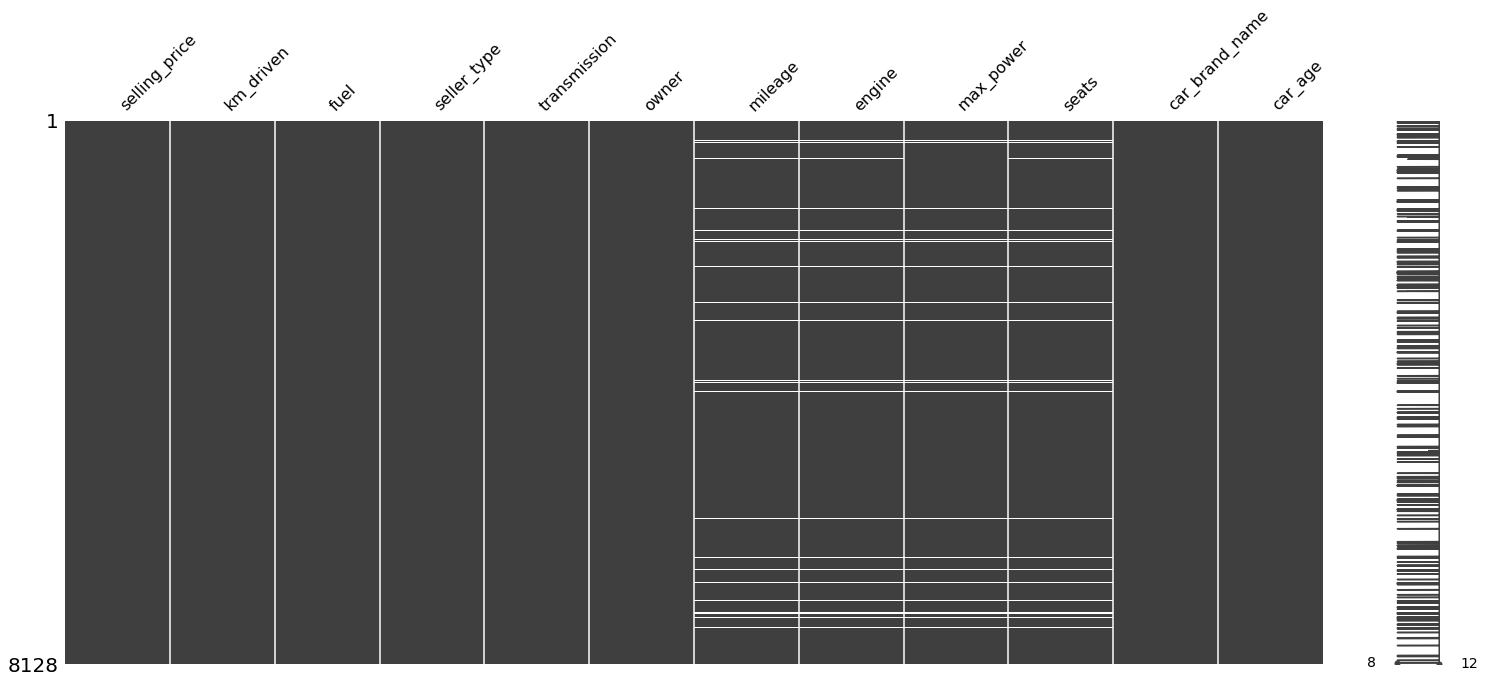

In [17]:
msno.matrix(df);

In [18]:
#fill null values with median (numeric) and frequent values (categoric)

numeric_data = [column for column in df.select_dtypes(["int", "float"])]
categoric_data = [column for column in df.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
        
#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [19]:
#check null values again

df.isnull().sum().sum()

0

 About filling nulls
    
    
    
We filled null values with medians of numeric variables and the most frequent values of categoric variables


In [20]:
#get class frequencies of some variables

print("Class frequencies of 'transmission' variable: \n\n", df["transmission"].value_counts())
print("Class frequencies of 'seller_type' variable: \n\n", df["seller_type"].value_counts())
print("Class frequencies of 'owner' variable: \n\n", df["owner"].value_counts())
print("Class frequencies of 'car_brand_name' variable: \n\n", df["car_brand_name"].value_counts())

Class frequencies of 'transmission' variable: 

 Manual       7078
Automatic    1050
Name: transmission, dtype: int64
Class frequencies of 'seller_type' variable: 

 Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: seller_type, dtype: int64
Class frequencies of 'owner' variable: 

 First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64
Class frequencies of 'car_brand_name' variable: 

 Maruti           2448
Hyundai          1415
Mahindra          772
Tata              734
Toyota            488
Honda             467
Ford              397
Chevrolet         230
Renault           228
Volkswagen        186
BMW               120
Skoda             105
Nissan             81
Jaguar             71
Volvo              67
Datsun             65
Mercedes-Benz      54
Fiat               47
Audi               40
Lexus              34
Jeep               31
M

In [21]:
#check correlation between the variables of dataset

df.corr()

,selling_price,km_driven,mileage,engine,max_power,seats,car_age
selling_price,1.000000,-0.225534,-0.125040,0.458345,0.747935,0.047135,-0.414092
km_driven,-0.225534,1.000000,-0.171746,0.198911,-0.040599,0.219860,0.418006
mileage,-0.125040,-0.171746,1.000000,-0.574128,-0.372897,-0.450578,-0.311657
engine,0.458345,0.198911,-0.574128,1.000000,0.703612,0.612220,-0.035851
max_power,0.747935,-0.040599,-0.372897,0.703612,1.000000,0.194556,-0.224704
seats,0.047135,0.219860,-0.450578,0.612220,0.194556,1.000000,-0.010222
car_age,-0.414092,0.418006,-0.311657,-0.035851,-0.224704,-0.010222,1.000000


# **Visualizations and Exploratory Data Analysis**

### Boxplot

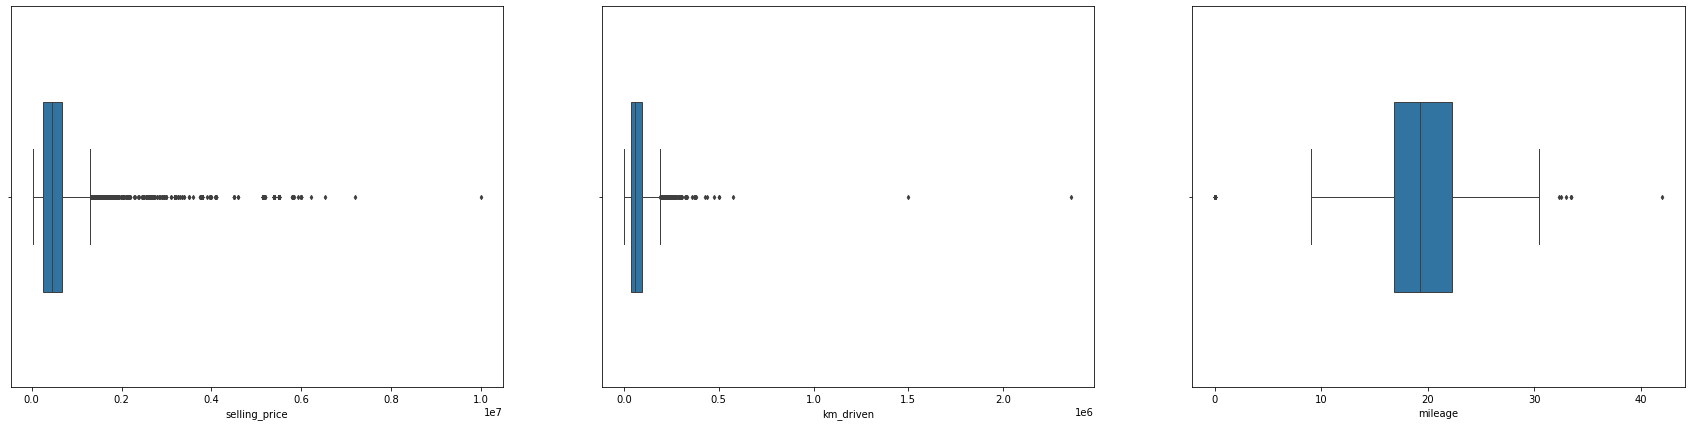

In [22]:
fig, axes = plt.subplots(1, 3, figsize = (30, 7))

sns.boxplot(ax = axes[0], x = "selling_price", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "km_driven", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "mileage", data = df, width = 0.5, fliersize = 3, linewidth = 1);

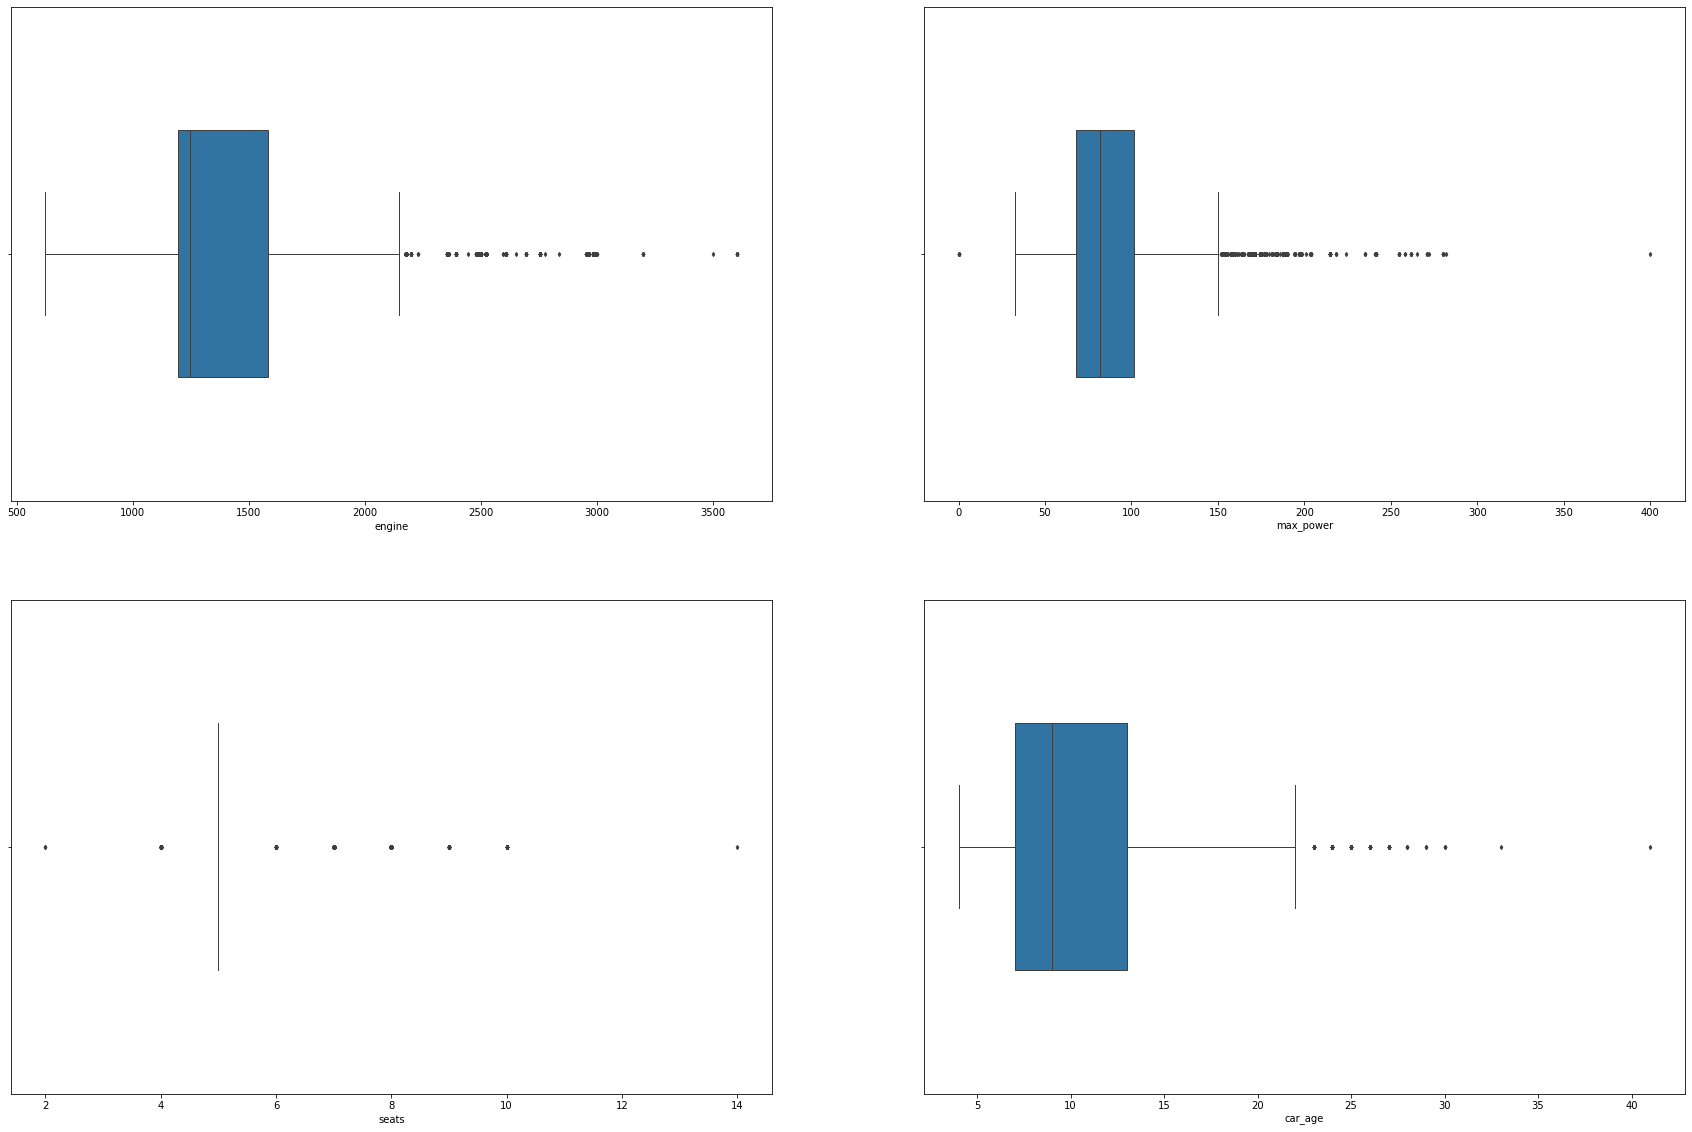

In [23]:
fig, axes = plt.subplots(2, 2, figsize = (30, 20))
axes = axes.flatten()

sns.boxplot(ax = axes[0], x = "engine", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "max_power", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "seats", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[3], x = "car_age", data = df, width = 0.5, fliersize = 3, linewidth = 1);

#### Histogram

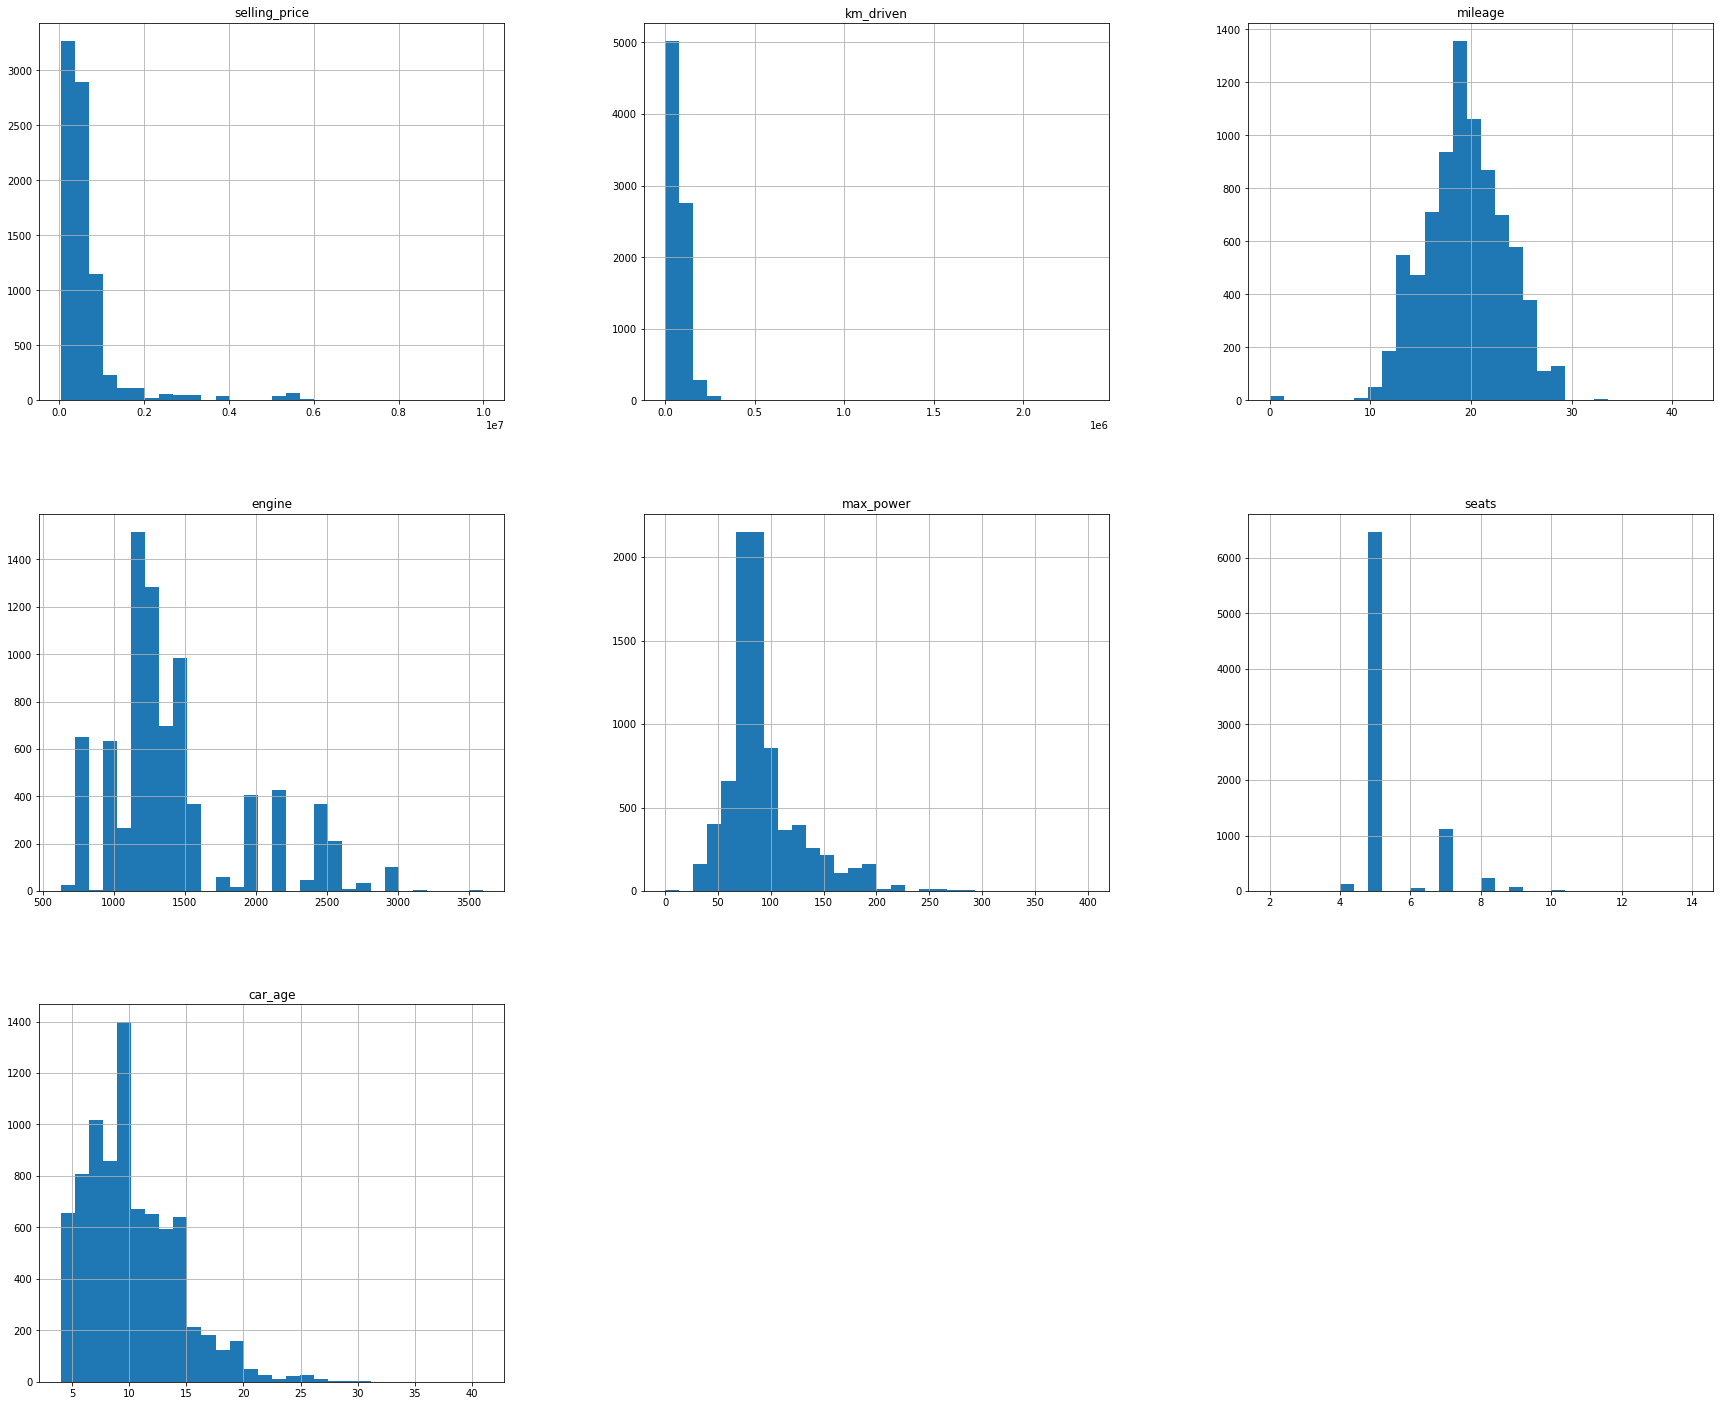

In [24]:
df.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

As it can be seen from the graphs above, the distributions of the variables (except 'mileage' variable) are not normal.

#### Catplot

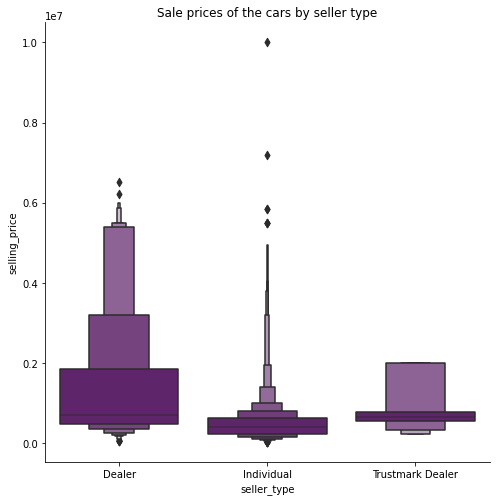

In [25]:
sns.catplot(x = "seller_type",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1,
            color = "#671A76",
            data = df).set(title = "Sale prices of the cars by seller type");

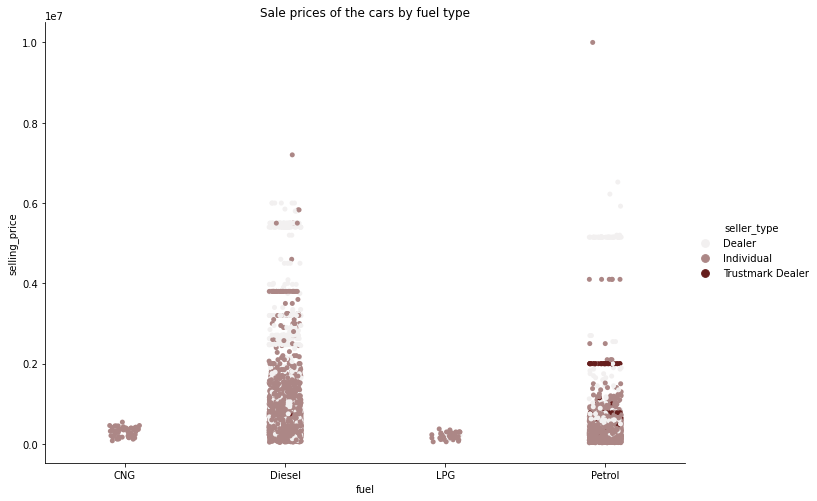

In [26]:
sns.catplot(x = "fuel",
            y = "selling_price",
            kind = "strip",
            hue = "seller_type",
            height = 7,
            aspect = 1.4,
            color = "#661E1D",
            data = df).set(title = "Sale prices of the cars by fuel type");

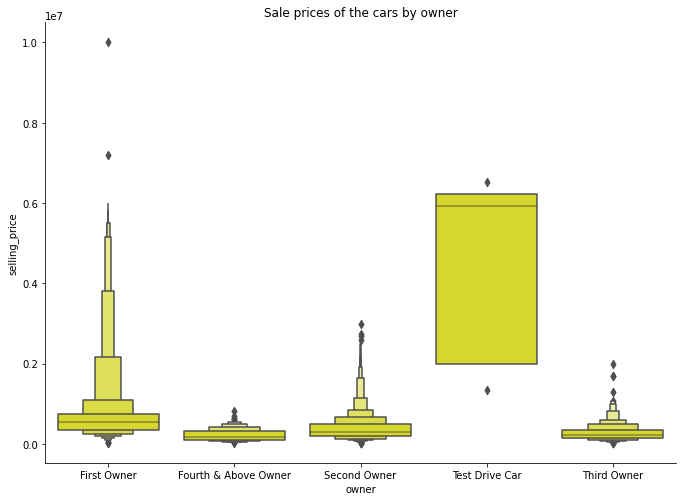

In [27]:
sns.catplot(x = "owner",
            y = "selling_price",
            kind = "boxen",
            height = 7,
            aspect = 1.37,
            color = "#F0F312",
            data = df).set(title = "Sale prices of the cars by owner");

#### Boxplot

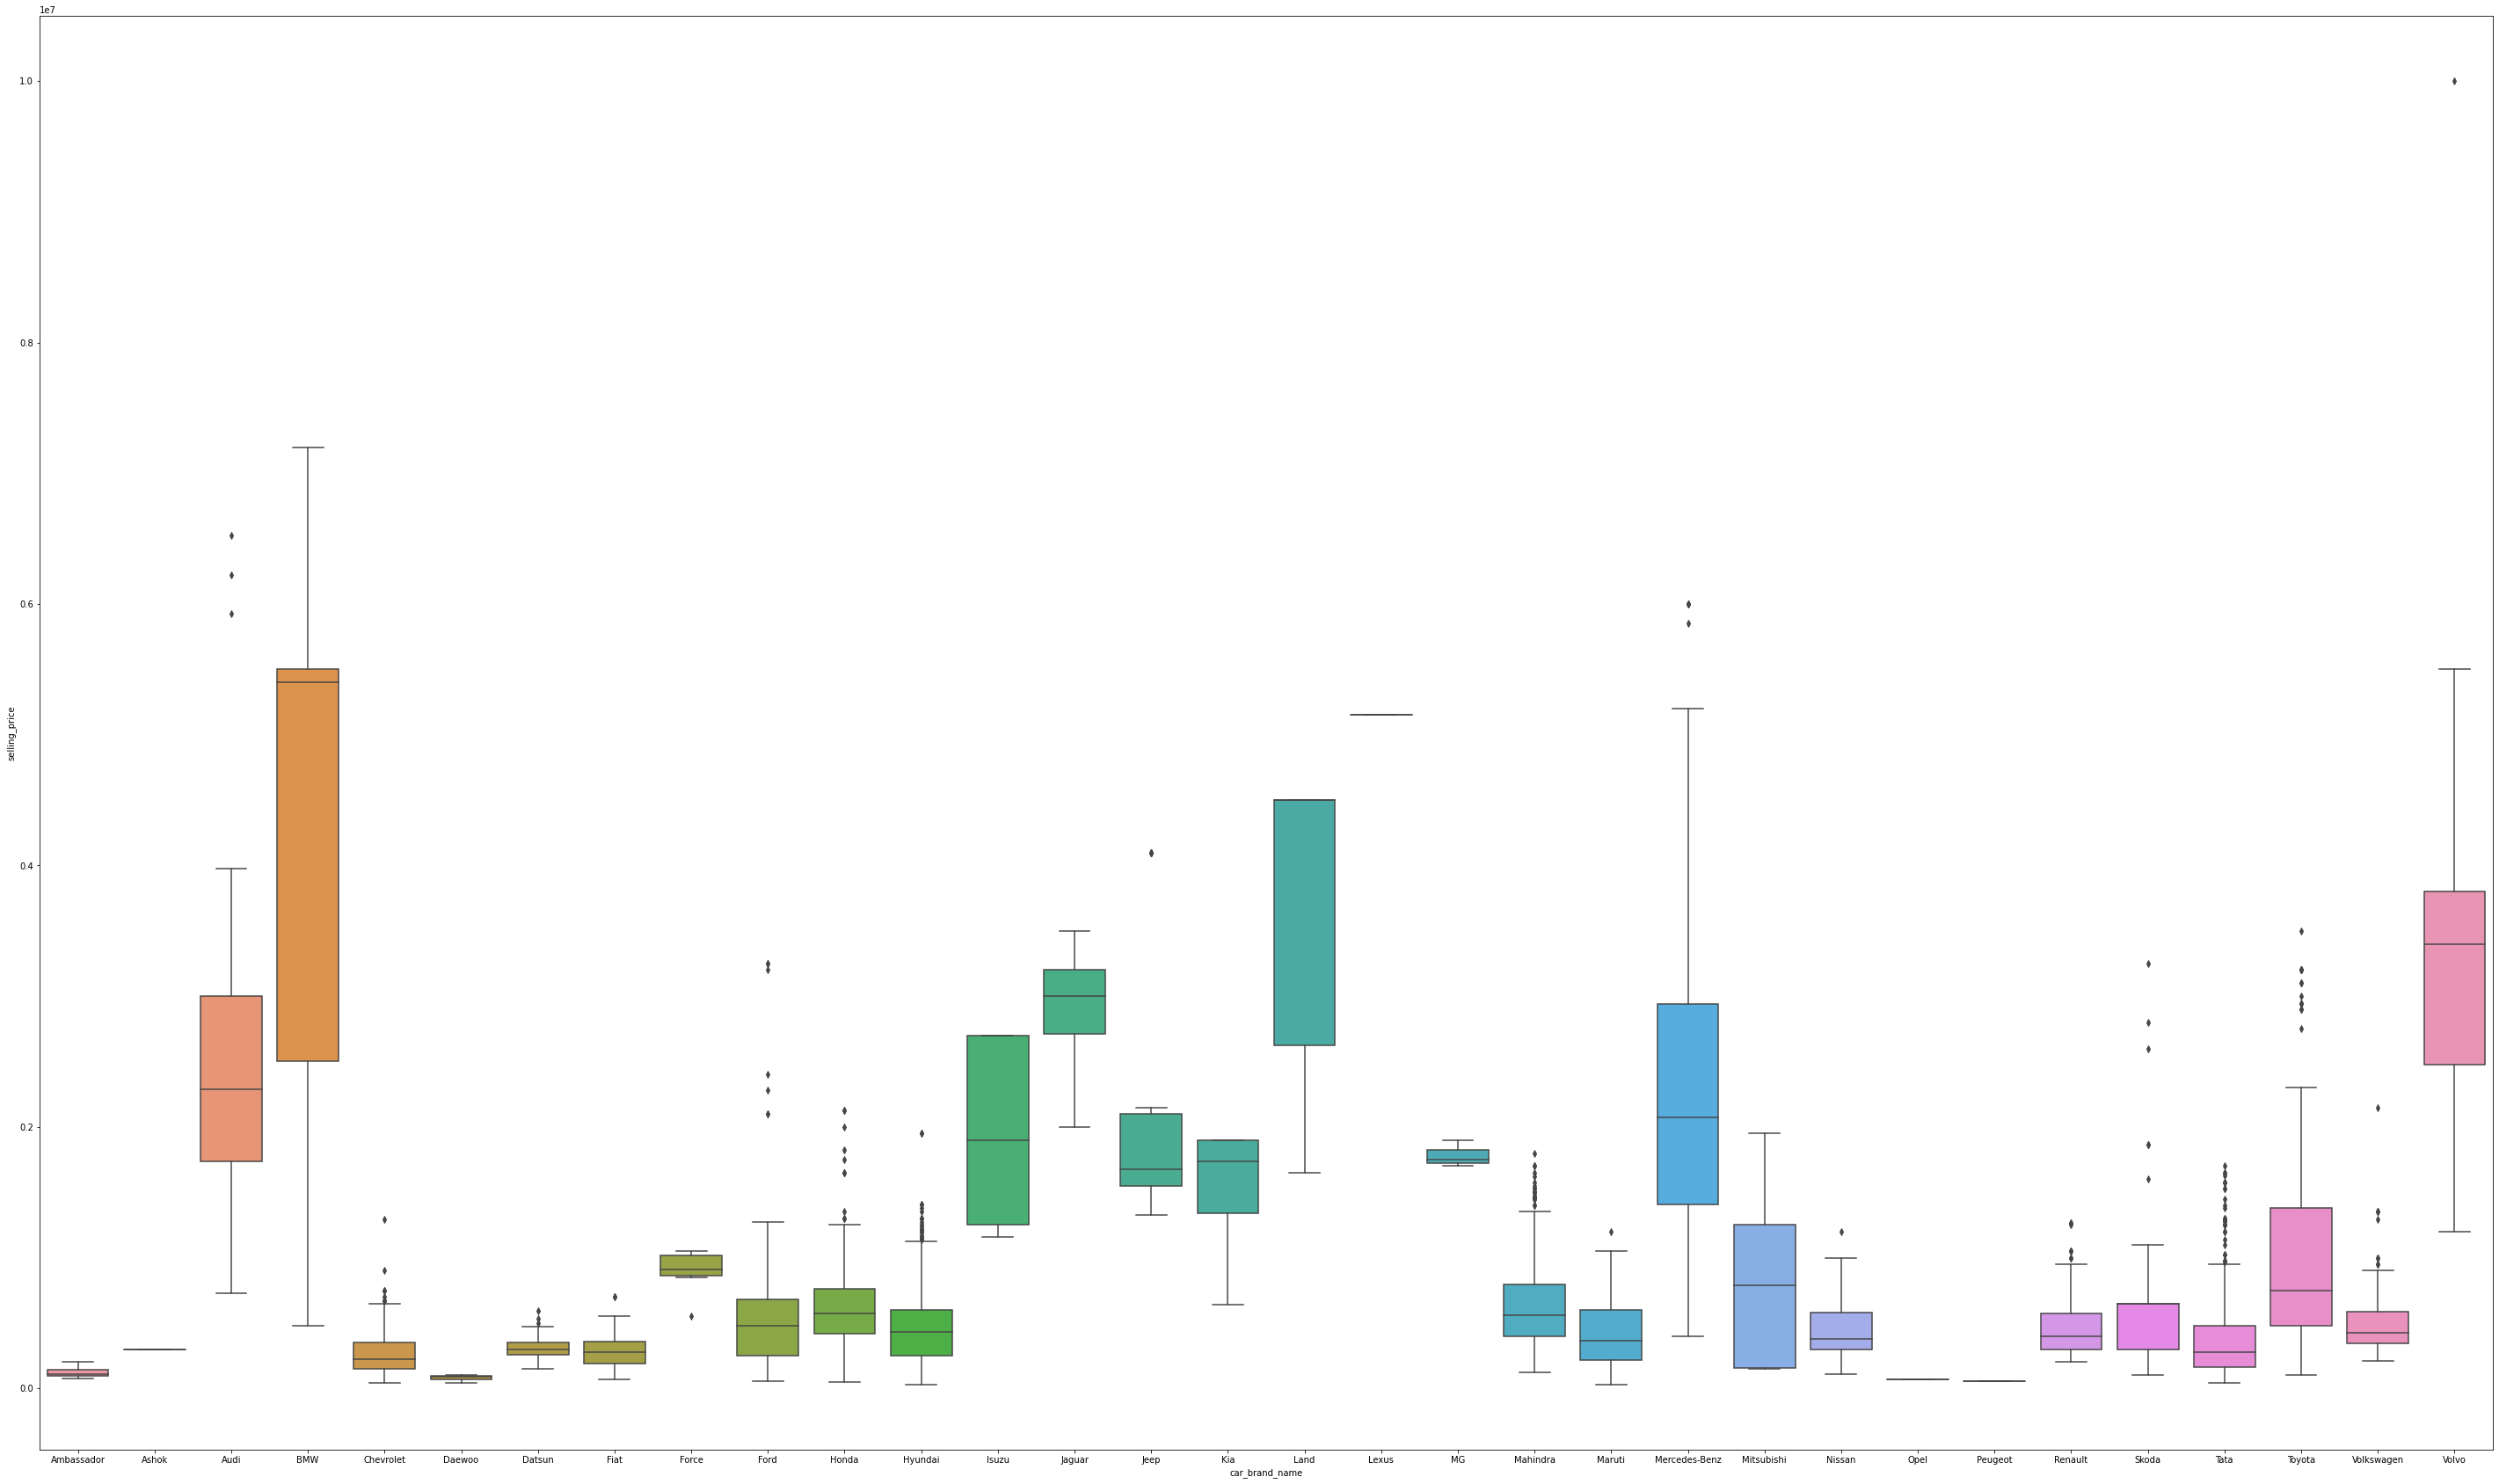

In [28]:
price = df["selling_price"]
brand = df["car_brand_name"]
dff = pd.concat([price, brand], axis = 1)      
f, ax = plt.subplots(figsize = (50, 30))
fig = sns.boxplot(dff["car_brand_name"], dff["selling_price"]);

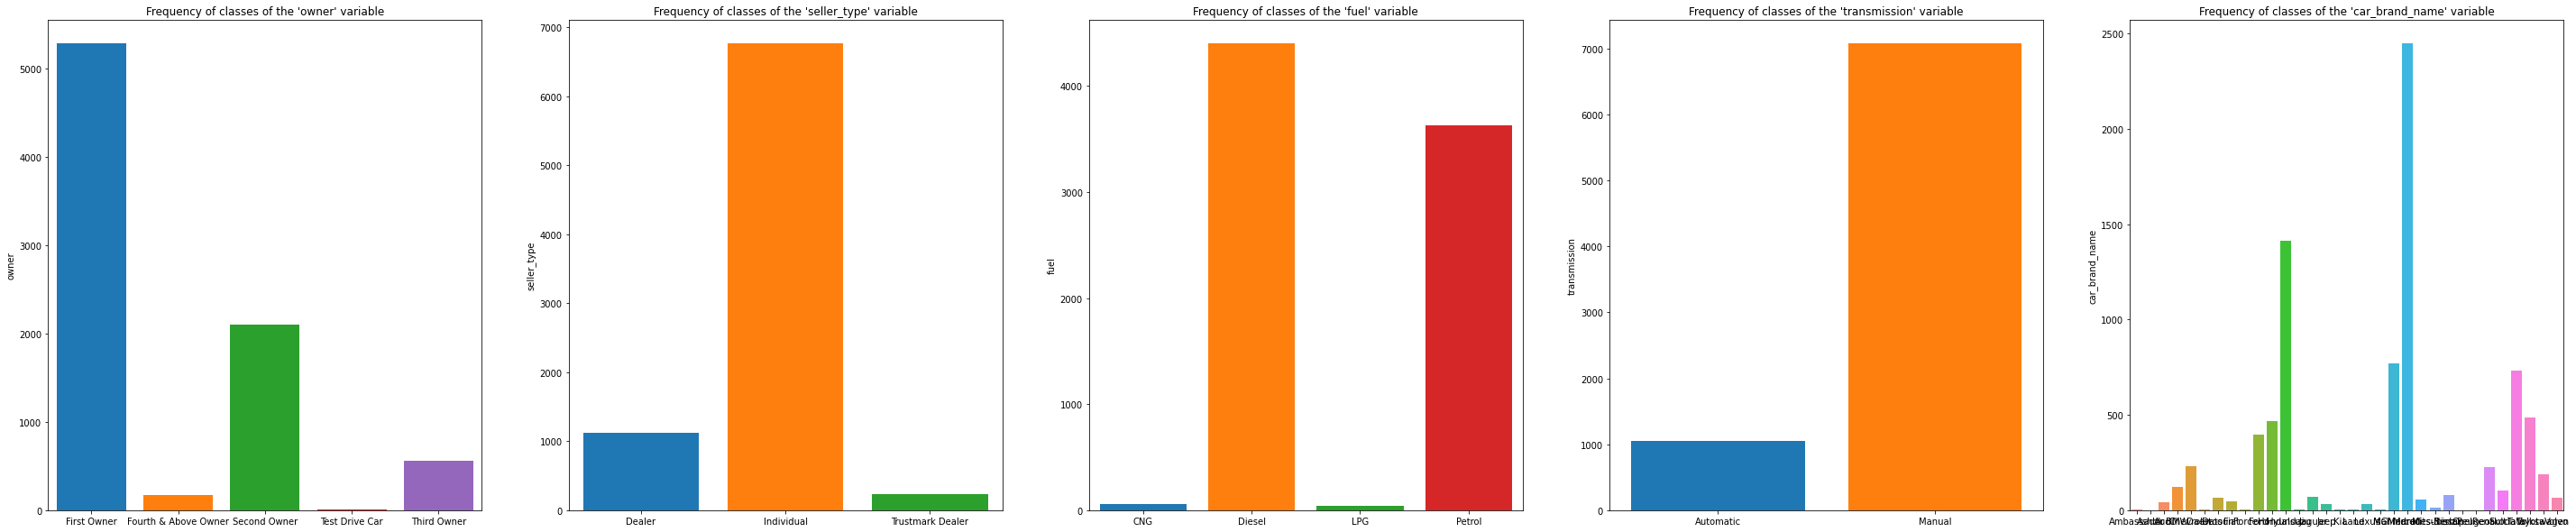

In [29]:
fig, axes = plt.subplots(1, 5, figsize = (50, 10))

sns.barplot(ax = axes[0], x = df["owner"].value_counts().index, y = df["owner"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'owner' variable");

sns.barplot(ax = axes[1], x = df["seller_type"].value_counts().index, y = df["seller_type"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'seller_type' variable");

sns.barplot(ax = axes[2], x = df["fuel"].value_counts().index, y = df["fuel"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'fuel' variable");

sns.barplot(ax = axes[3], x = df["transmission"].value_counts().index, y = df["transmission"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'transmission' variable");

sns.barplot(ax = axes[4], x = df["car_brand_name"].value_counts().index, y = df["car_brand_name"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'car_brand_name' variable");

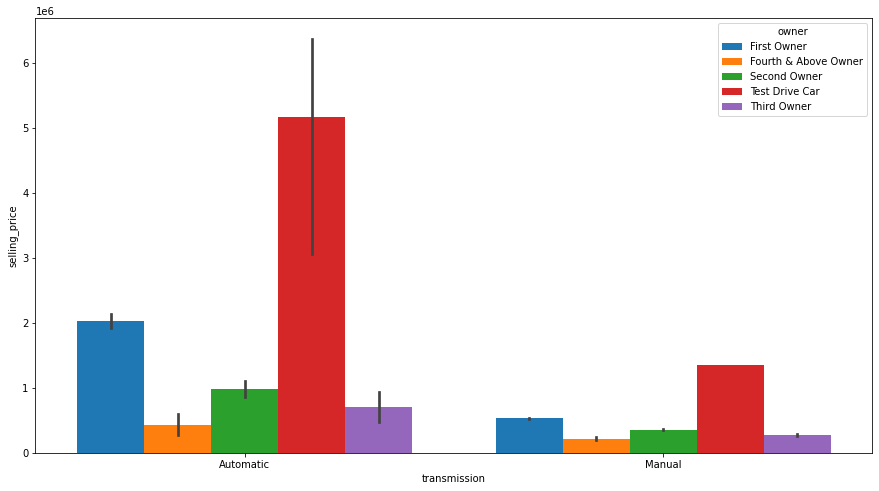

In [30]:
plt.figure(figsize = (15, 8))
sns.barplot(x = "transmission", y = "selling_price", hue = "owner", data = df, saturation = 1);

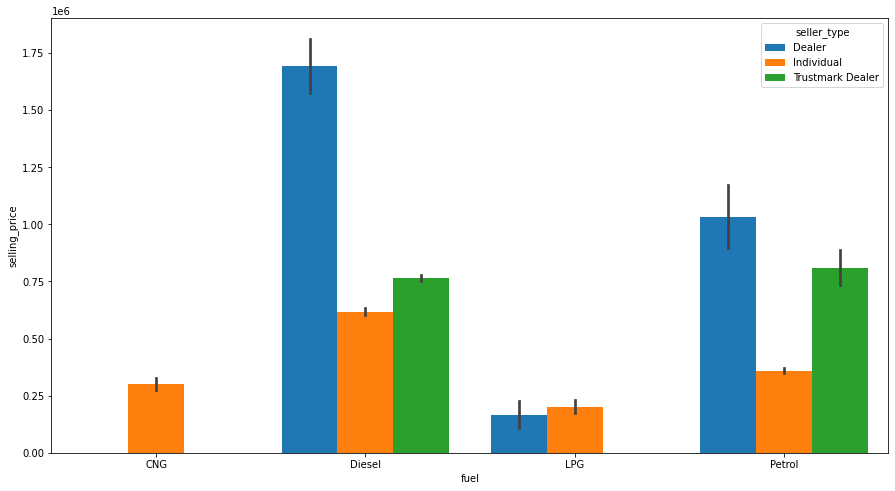

In [31]:
plt.figure(figsize = (15, 8))
sns.barplot(x = "fuel", y = "selling_price", hue = "seller_type", data = df, saturation = 1);

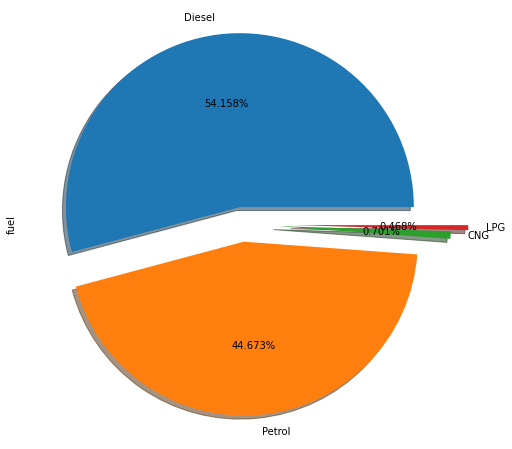

In [32]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["fuel"].value_counts().plot.pie(explode = [0.1, 0.1, 0.2, 0.3], autopct='%1.3f%%', shadow = True);

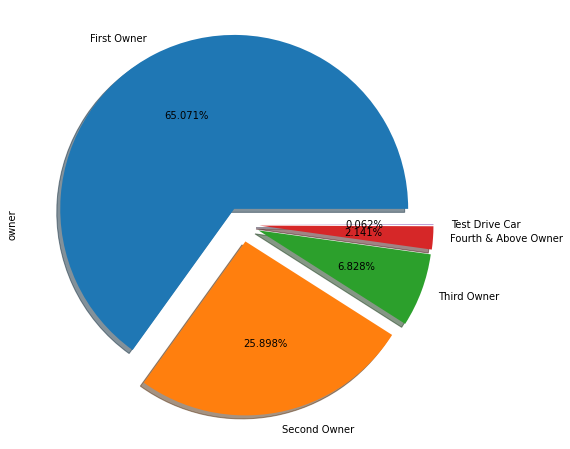

In [33]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "#FFFFFF")
df["owner"].value_counts().plot.pie(explode = [0.1, 0.1, 0.1, 0.1, 0.1], autopct='%1.3f%%', shadow = True);

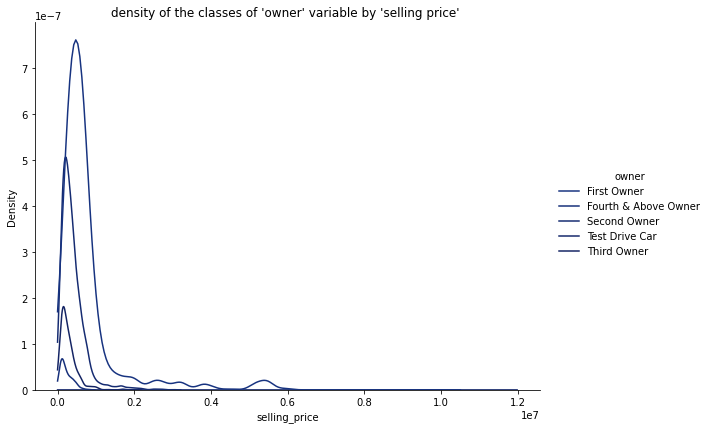

In [34]:
sns.displot(data = df, x = "selling_price", hue = "owner", kind = "kde", height = 6,
            aspect = 1.3, clip=(0, None), palette="ch:rot=-.25, hue = 2, light=.20"
).set(title = "density of the classes of 'owner' variable by 'selling price' ");

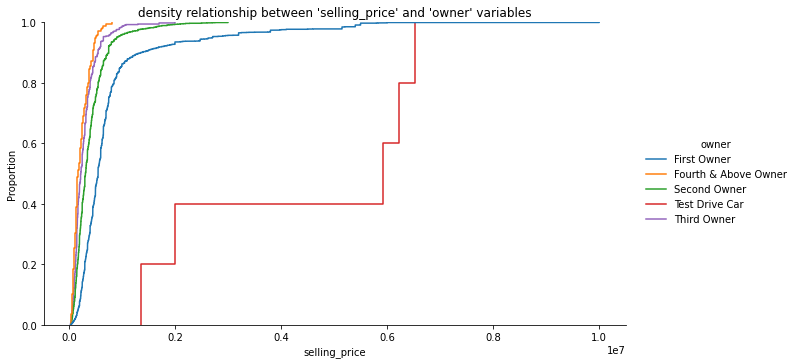

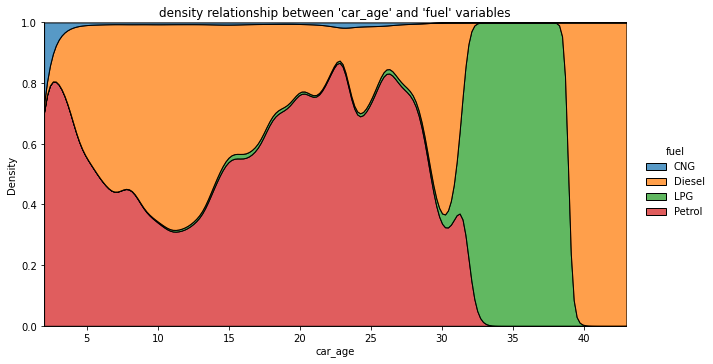

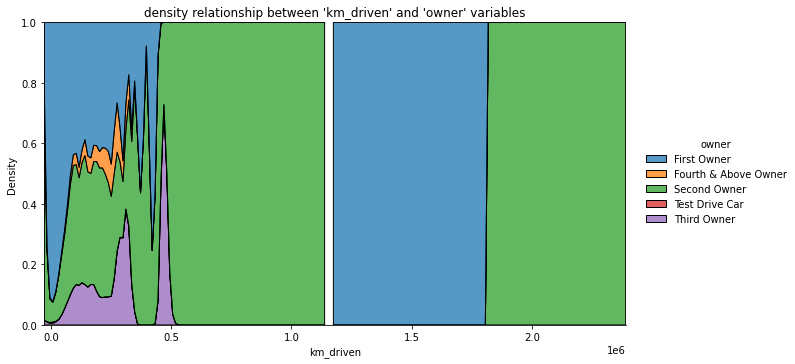

In [35]:
sns.displot(
    data = df, x = "selling_price", hue = "owner",
    kind = "ecdf", height = 5, aspect = 1.8).set(title =  "density relationship between 'selling_price' and 'owner' variables");

sns.displot(
    data = df, x = "car_age", hue = "fuel",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'car_age' and 'fuel' variables");

sns.displot(
    data = df, x = "km_driven", hue = "owner",
    kind = "kde", height = 5, aspect = 1.8, multiple="fill").set(title = "density relationship between 'km_driven' and 'owner' variables");

#### Correlation and heatmap

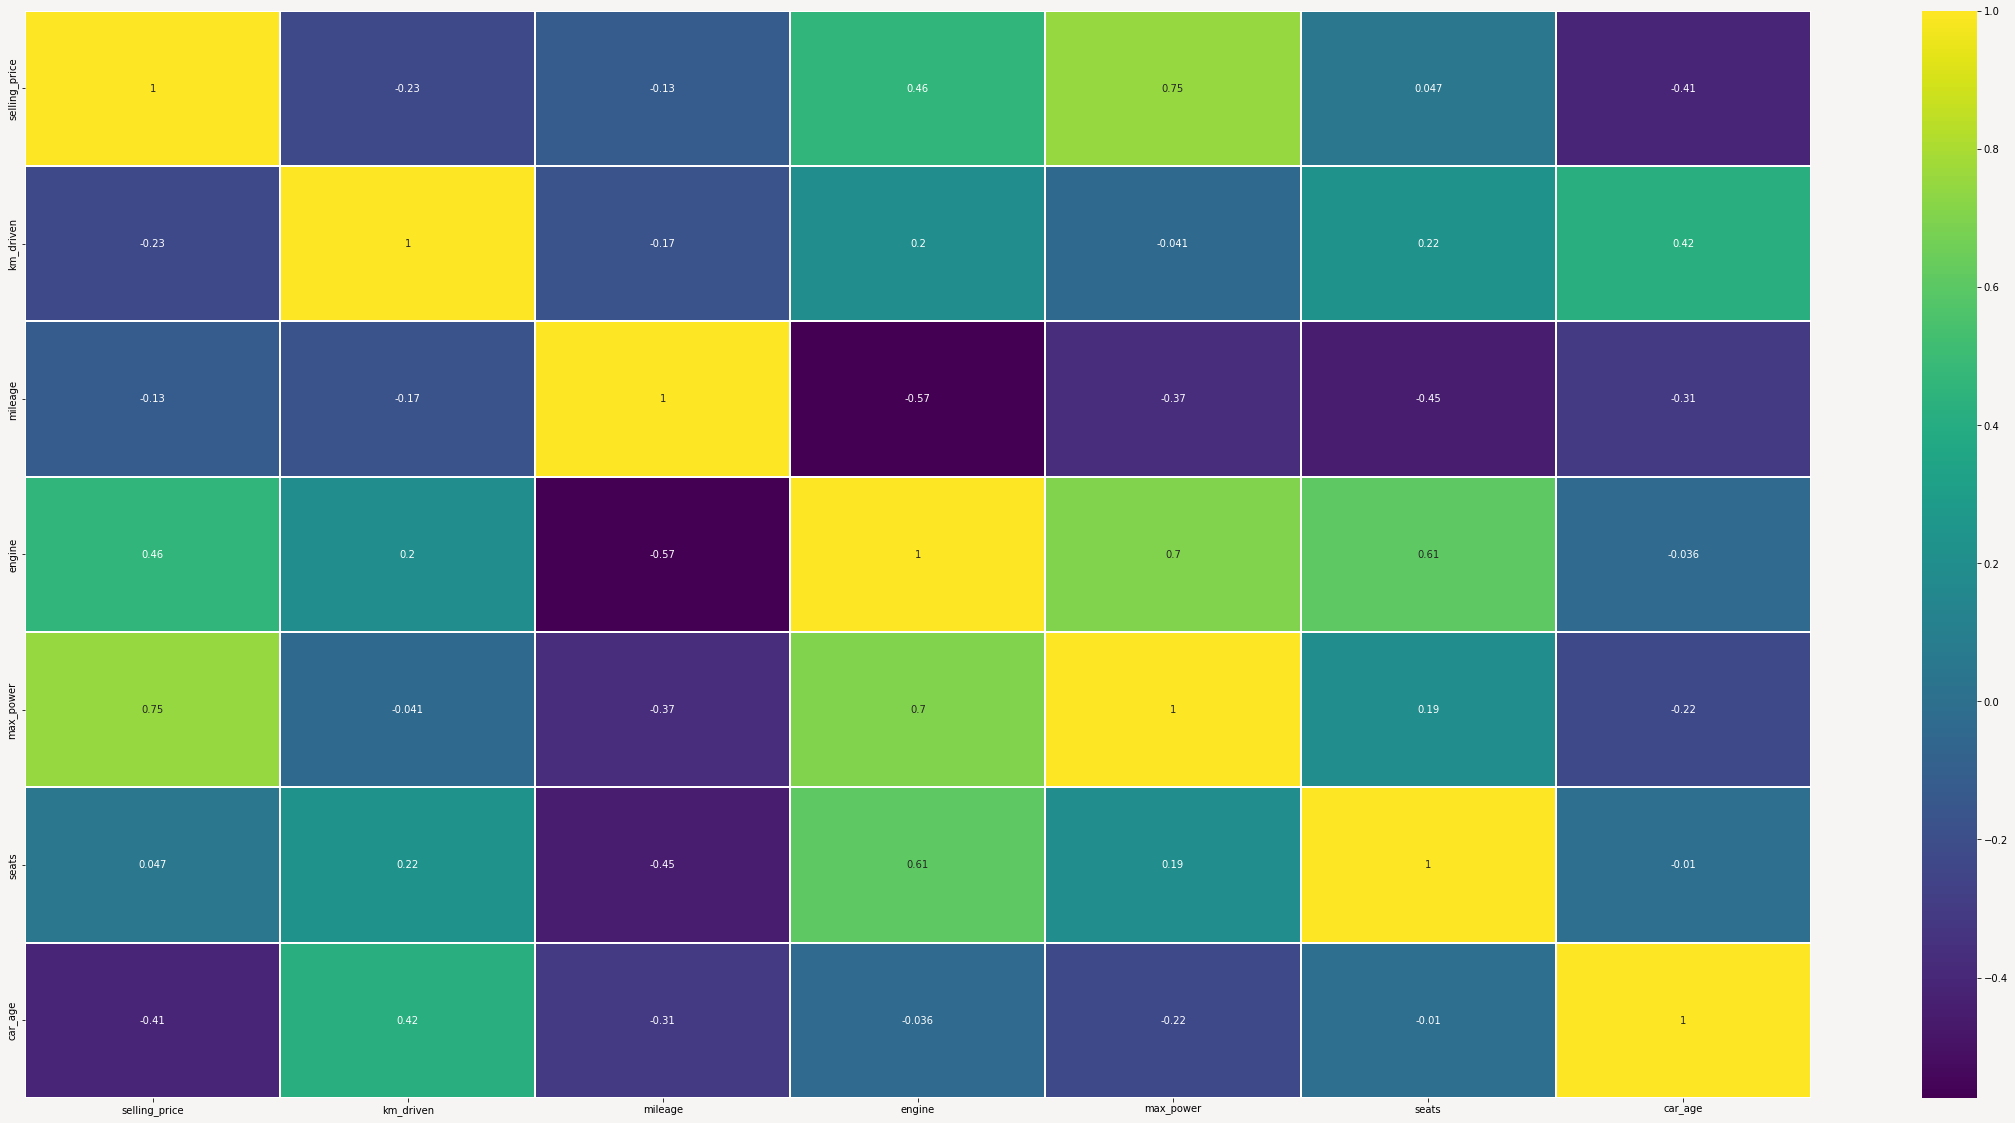

In [36]:
plt.figure(figsize = [40, 20], facecolor = "#F7F4F4")
sns.heatmap(df.corr(), annot = True, linewidths = 2, linecolor = "white", cmap = "viridis");

In [37]:
df.corr().style.background_gradient(cmap = "binary")

,selling_price,km_driven,mileage,engine,max_power,seats,car_age
selling_price,1.000000,-0.225534,-0.125040,0.458345,0.747935,0.047135,-0.414092
km_driven,-0.225534,1.000000,-0.171746,0.198911,-0.040599,0.219860,0.418006
mileage,-0.125040,-0.171746,1.000000,-0.574128,-0.372897,-0.450578,-0.311657
engine,0.458345,0.198911,-0.574128,1.000000,0.703612,0.612220,-0.035851
max_power,0.747935,-0.040599,-0.372897,0.703612,1.000000,0.194556,-0.224704
seats,0.047135,0.219860,-0.450578,0.612220,0.194556,1.000000,-0.010222
car_age,-0.414092,0.418006,-0.311657,-0.035851,-0.224704,-0.010222,1.000000


As seen there is high correlation between some of the variables:
* between 'mileage' and 'engine' variables - -0.57
* between 'max_power' and 'engine' variables - 0.70
* between 'seats' and 'engine' variables - 0.61
* between 'max_power' and 'selling_price' variables - 0.74
    
There is middle level of correlation between other variables too.

## **Fix skewness of the variables**

### Target variable

In [38]:
print("Basic descriptive statistics of the target variable - 'selling_price': \n\n",
      df["selling_price"].describe())

Basic descriptive statistics of the target variable - 'selling_price': 

 count    8.128000e+03
mean     6.382718e+05
std      8.062534e+05
min      2.999900e+04
25%      2.549990e+05
50%      4.500000e+05
75%      6.750000e+05
max      1.000000e+07
Name: selling_price, dtype: float64


## **Basic statistics of the target variable - 'selling_price'**
* average of the target variable is 638271 USD

* standard deviation of the target variable is 806253 USD

* minimum of the target variable is 29999 USD

* maximum of the target variable is 10000000 USD

* median of the target variable is 450000 USD

# Skew and Kurt

In [39]:
print("Skewness of target variable: ", df["selling_price"].skew())
print("Kurtosis of target variable: ", df["selling_price"].kurt())

Skewness of target variable:  4.193533440675855
Kurtosis of target variable:  21.081289012186755


 **Positive skewness and high kurtosis**
    
* Positive skewness, more weight is on the left side of the distribution.
    
* Kurtosis is greater than 3. It is leptokurtic.

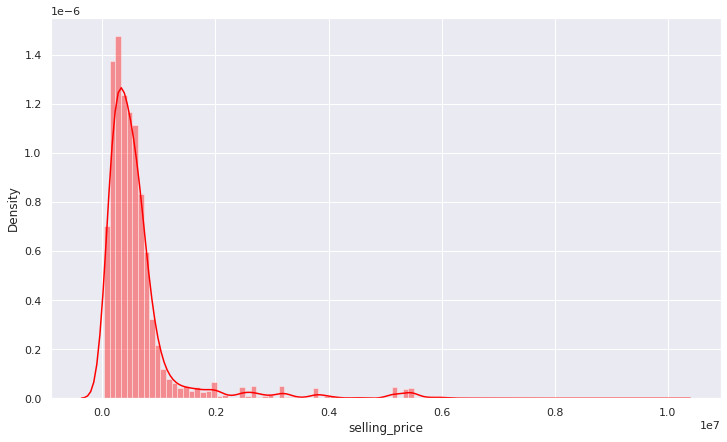

In [40]:
sns.set(rc = {"figure.figsize" : (12, 7)})
sns.distplot(df["selling_price"], bins = 100, color = "red");

 What the graph shows?
    
We see positive skewness from the graph above. As the graphs shows, more weight is on the left side of the distribution. We will try to fix it using "log1p" function of numpy.

In [41]:
df["selling_price"] = np.log1p(df["selling_price"])
df["selling_price"].head(n = 10)

0    13.017005
1    12.821261
2    11.970357
3    12.323860
4    11.775297
5    12.994532
6    11.472114
7    10.714440
8    12.765691
9    12.206078
Name: selling_price, dtype: float64

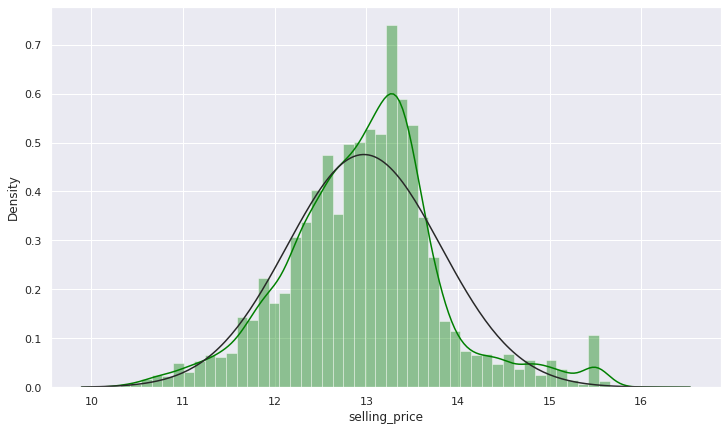

In [42]:
sns.distplot(df["selling_price"], fit = norm, color = "green");

 What the graph shows?
    
As seen from the graph above, we could fix the skewness and distribution of target variable is normal

In [43]:
# get skewness of other numeric variables

numeric_data = [column for column in df.select_dtypes(["int", "float"])]
for col in numeric_data:
    print("Skewness of", col, "variable is:", df[col].skew())

Skewness of selling_price variable is: 0.22327004522860716
Skewness of km_driven variable is: 11.170909783549087
Skewness of mileage variable is: -0.14220847114521287
Skewness of engine variable is: 1.1753055440141613
Skewness of max_power variable is: 1.6595575154307947
Skewness of seats variable is: 2.015507247545297
Skewness of car_age variable is: 1.072292893616034


In [44]:
# fix skewness  of them with 'log1p' function

for c in numeric_data:
    df[c] = np.log1p(df[c])

**All skewness fixed**
    
We could fix the skewness of all other variables. So let's continue...

In [45]:
df.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,2.640271,11.887938,Diesel,Individual,Manual,First Owner,3.194583,7.130099,4.317488,1.791759,Maruti,2.397895
1,2.626208,11.695255,Diesel,Individual,Manual,Second Owner,3.097386,7.312553,4.649378,1.791759,Skoda,2.397895
2,2.562666,11.849405,Petrol,Individual,Manual,Third Owner,2.928524,7.311886,4.369448,1.791759,Honda,2.944439
3,2.589556,11.751950,Diesel,Individual,Manual,First Owner,3.178054,7.242082,4.510860,1.791759,Hyundai,2.708050
4,2.547513,11.695255,Petrol,Individual,Manual,First Owner,2.839078,7.169350,4.490881,1.791759,Maruti,2.890372


# **Split and encode the dataset**

In [46]:
# select dependent variable (label)

y = df["selling_price"]

In [47]:
# select independent variable (estimator)
x = df.drop("selling_price", axis = 1)

#encode the variables of the dataset
x = pd.get_dummies(x, drop_first = True)

In [48]:
y.shape, x.shape

((8128,), (8128, 47))

In [49]:
x.head()

,km_driven,mileage,engine,max_power,seats,car_age,fuel_Diesel,...,car_brand_name_Peugeot,car_brand_name_Renault,car_brand_name_Skoda,car_brand_name_Tata,car_brand_name_Toyota,car_brand_name_Volkswagen,car_brand_name_Volvo
0,11.887938,3.194583,7.130099,4.317488,1.791759,2.397895,1,...,0,0,0,0,0,0,0
1,11.695255,3.097386,7.312553,4.649378,1.791759,2.397895,1,...,0,0,1,0,0,0,0
2,11.849405,2.928524,7.311886,4.369448,1.791759,2.944439,0,...,0,0,0,0,0,0,0
3,11.751950,3.178054,7.242082,4.510860,1.791759,2.708050,1,...,0,0,0,0,0,0,0
4,11.695255,2.839078,7.169350,4.490881,1.791759,2.890372,0,...,0,0,0,0,0,0,0


In [50]:
# Split the dataset into x_train (y_train) and x_test (y_test) sets

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 1)
print(x_train.shape)
print(x_test.shape)

(6502, 47)
(1626, 47)


#### Robust Scaling

In [51]:
rob_scaler = RobustScaler()
rob_scaler.fit(x_train)
x_train = rob_scaler.transform(x_train)
x_test = rob_scaler.transform(x_test)

# **Predicting with machine learning models**

### Define cross validation metrics and setup kfold

In [52]:
k_fold = KFold(n_splits = 10, random_state = 11, shuffle = True)

In [53]:
def cv_rmse(model, X = x_train):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
    return rmse

def rmsle(y, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y, y_pred, squared = False))
    return rmsle

### Building ML models

In [54]:
knn = KNeighborsRegressor(n_neighbors=5)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)
lg = LinearRegression()
lasso = LassoCV(alphas = [1e-10, 1e-8, 1e-7, 1e-5, 1e-2, 9e-4, 9e-3, 5e-4, 3e-4, 1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.6, 1, 3, 5, 7, 14, 18, 25, 30, 45, 50, 70, 90], n_jobs = -1, cv = k_fold)


In [55]:
lg.fit(x_train, y_train)
y_pred_test = lg.predict(x_test)

y_pred_test

from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
from sklearn.metrics import mean_squared_error
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_test))
import numpy as np
from sklearn.metrics import mean_squared_error
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
from sklearn.metrics import r2_score
print('R-squared:', r2_score(y_test, y_pred_test))

Mean Absolute Error: 0.014986360221194246
Mean Squared Error: 0.000412141057291751
Root Mean Squared Error: 0.020301257529812065
R-squared: 0.8786883315485498


In [56]:
rf = rf.fit(x_train, y_train)
y_pred_test = rf.predict(x_test)

from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
from sklearn.metrics import mean_squared_error
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_test))
import numpy as np
from sklearn.metrics import mean_squared_error
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
from sklearn.metrics import r2_score
print('R-squared:', r2_score(y_test, y_pred_test))

Mean Absolute Error: 0.010291827944936915
Mean Squared Error: 0.00024379728096191917
Root Mean Squared Error: 0.015614009125202891
R-squared: 0.928239484045189


In [57]:
knn = knn.fit(x_train, y_train)
y_pred_test = knn.predict(x_test)

from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
from sklearn.metrics import mean_squared_error
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_test))
import numpy as np
from sklearn.metrics import mean_squared_error
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared:', r2_score(y_test, y_pred_test))

Mean Absolute Error: 0.013068226417575976
Mean Squared Error: 0.00037138196525133605
Root Mean Squared Error: 0.01927127305736017
R-squared: 0.8906855673796035


In [58]:
lasso = lasso.fit(x_train, y_train)
y_pred_test = lasso.predict(x_test)

from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
from sklearn.metrics import mean_squared_error
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_test))
import numpy as np
from sklearn.metrics import mean_squared_error
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
from sklearn.metrics import r2_score
print('R-squared:', r2_score(y_test, y_pred_test))

Mean Absolute Error: 0.014986937084396286
Mean Squared Error: 0.00041218696153753437
Root Mean Squared Error: 0.020302388074744663
R-squared: 0.8786748198623286


### Make prediction on test dataset

In [59]:
y_pred = np.expm1(stacked_model.predict(x_test))
y_pred[0:5]

NameError: name 'stacked_model' is not defined

In [ ]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('R-squared: {}'.format(metrics.r2_score(y_test, y_pred_test)))

In [ ]:
plt.scatter(y_test, y_pred_test);
plt.xlabel("actual")
plt.ylabel("prediction")